In [39]:
### Function to visualize the results of Grid Search with 2 hyperparameters ###
def plot_grid_search_2d(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1),len(grid_param_2))
    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_1):
        ax.plot(grid_param_2, scores_mean[idx,:], '-o', label= name_param_1 + ': ' + str(val))
    ax.set_title("Grid Search Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_2, fontsize=10)
    ax.set_ylabel('CV Average Validation Accuracy', fontsize=10)
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')

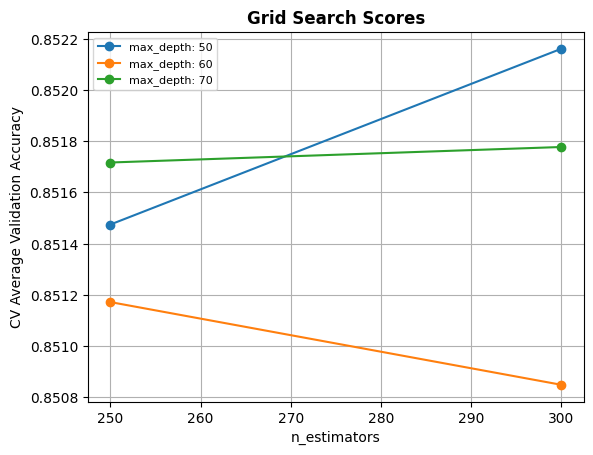

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

data_path = r"C:\Users\ferijoni\OneDrive - FERI AG\Dokumente\6.Sem\BD\fs-classify-products\data\balanced_data.csv"
balanced_data = pd.read_csv(data_path)
# Features und Ziel
X = balanced_data.drop(columns='target')
Y = balanced_data['target']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)

# Klassifikationsmodell
RForClassCV = RandomForestClassifier(random_state=0)

# Grid definieren
param_grid = {
    'max_depth': [50,60,70],
    'n_estimators': [250,300]}

# GridSearchCV Setup
model = RandomForestClassifier(random_state=0)
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train, Y_train)

# Plot aufrufen
import matplotlib.pyplot as plt
plot_grid_search_2d(grid.cv_results_, param_grid['max_depth'], param_grid['n_estimators'],'max_depth', 'n_estimators')

plt.show()

In [41]:
# Klassifikationsmodell mit besten Parametern aus CV
final_rf_clf = RandomForestClassifier(random_state=0)
final_rf_clf.set_params(**CV_rfmodel.best_params_)

# Modell trainieren
final_rf_clf.fit(X_train, Y_train)

# Accuracy berechnen
train_acc = final_rf_clf.score(X_test, Y_test)


print(f"Test: {train_acc:.4f}")



Test: 0.8421
